In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, classification_report,
                             confusion_matrix)

sns.set_style("whitegrid")


In [57]:
df = pd.read_csv("Global_Pollution_Analysis.csv")

# Clean column names
df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("%", "Percent")
)

print(df.head())
print(df.info())


        Country  Year  Air_Pollution_Index  Water_Pollution_Index  \
0       Hungary  2005               272.70                 124.27   
1     Singapore  2001                86.72                  60.34   
2       Romania  2016                91.59                  83.36   
3  Cook Islands  2018               280.61                  67.16   
4      Djibouti  2008               179.16                 127.53   

   Soil_Pollution_Index  Industrial_Waste_in_tons  Energy_Recovered_in_GWh  \
0                 51.95                  94802.83                   158.14   
1                117.22                  56283.92                   498.04   
2                121.72                  56256.02                   489.51   
3                 93.58                  74864.73                   145.18   
4                121.55                  76862.06                    40.38   

   CO2_Emissions_in_MT  Renewable_Energy_Percent  \
0                 5.30                     41.11   
1           

In [58]:
print("Missing Values:\n", df.isnull().sum())

# Median imputation for numeric columns
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())


Missing Values:
 Country                                 0
Year                                    0
Air_Pollution_Index                     0
Water_Pollution_Index                   0
Soil_Pollution_Index                    0
Industrial_Waste_in_tons                0
Energy_Recovered_in_GWh                 0
CO2_Emissions_in_MT                     0
Renewable_Energy_Percent                0
Plastic_Waste_Produced_in_tons          0
Energy_Consumption_Per_Capita_in_MWh    0
Population_in_millions                  0
GDP_Per_Capita_in_USD                   0
dtype: int64


In [59]:
df["Total_Pollution_Index"] = (
    df["Air_Pollution_Index"] +
    df["Water_Pollution_Index"] +
    df["Soil_Pollution_Index"]
) / 3


In [60]:
df["Year_Trend"] = df["Year"] - df["Year"].min()


In [61]:
df = df.sort_values(["Country", "Year"])
df["CO2_Trend"] = (
    df.groupby("Country")["CO2_Emissions_in_MT"]
      .diff()
      .fillna(0)
)


In [62]:
df["Energy_per_Capita_Calc"] = (
    df["Energy_Recovered_in_GWh"] * 1000
) / (df["Population_in_millions"] * 1_000_000)


In [63]:
print(df.describe())


              Year  Air_Pollution_Index  Water_Pollution_Index  \
count   200.000000            200.00000             200.000000   
mean   2009.335000            180.62695             115.068100   
std       5.765325             67.07331              47.580911   
min    2000.000000             50.30000              31.130000   
25%    2004.000000            134.97250              74.550000   
50%    2010.000000            183.38500             112.305000   
75%    2014.000000            237.42500             157.477500   
max    2019.000000            297.95000             199.320000   

       Soil_Pollution_Index  Industrial_Waste_in_tons  \
count            200.000000                 200.00000   
mean              76.488550               52891.68150   
std               39.692727               27224.49169   
min               11.150000                1019.37000   
25%               40.895000               31201.97250   
50%               78.600000               55299.15000   
75%   

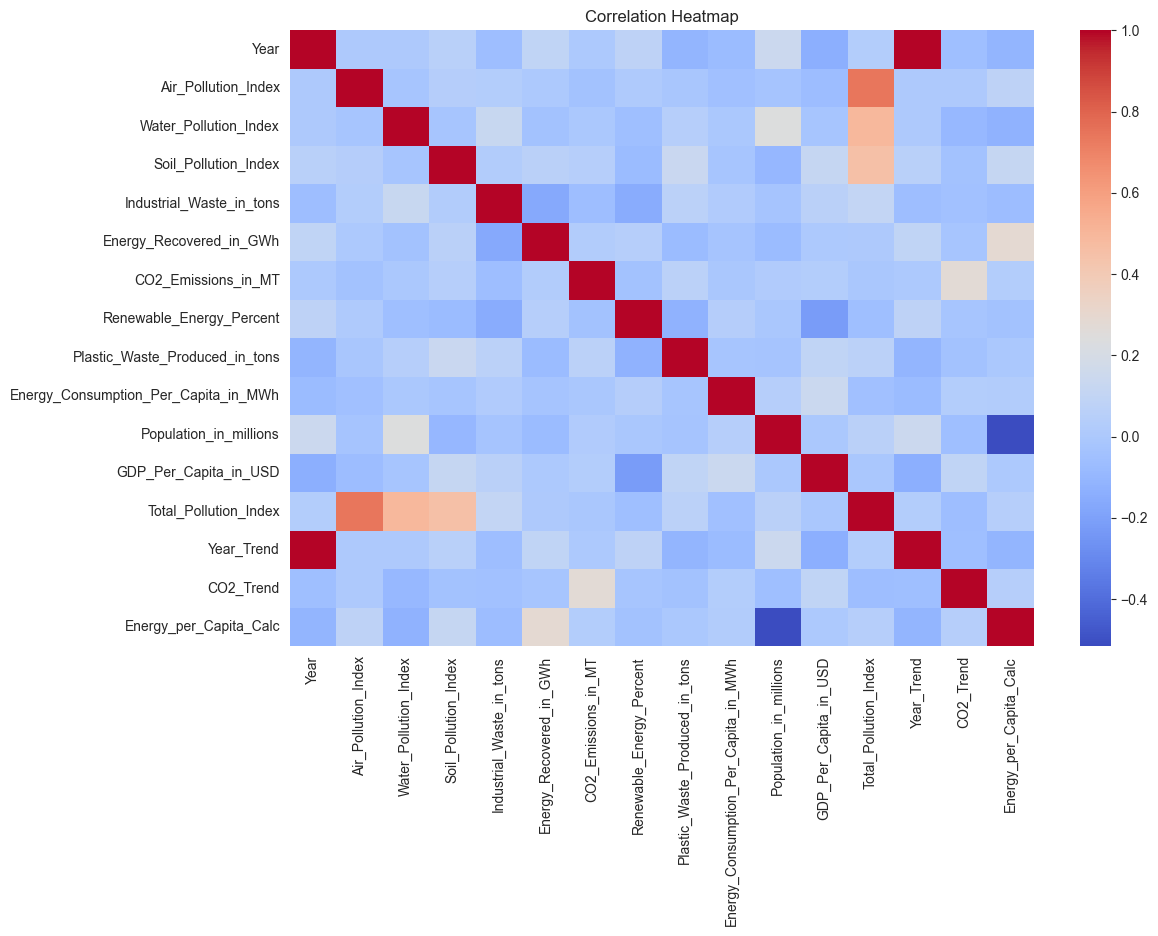

In [64]:
plt.figure(figsize=(12,8))

numeric_df = df.select_dtypes(include=np.number)

sns.heatmap(numeric_df.corr(), cmap="coolwarm")

plt.title("Correlation Heatmap")
plt.show()


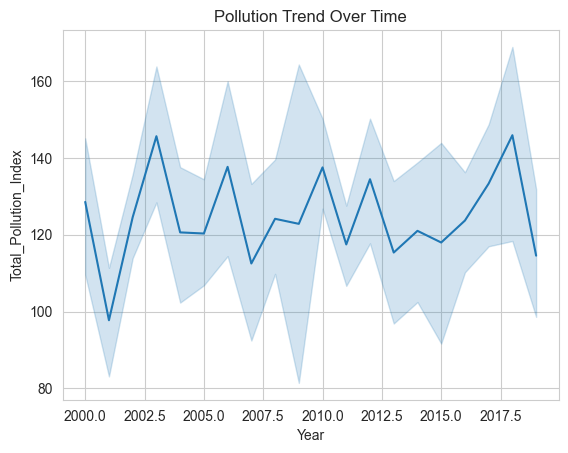

In [65]:
sns.lineplot(data=df, x="Year", y="Total_Pollution_Index")
plt.title("Pollution Trend Over Time")
plt.show()


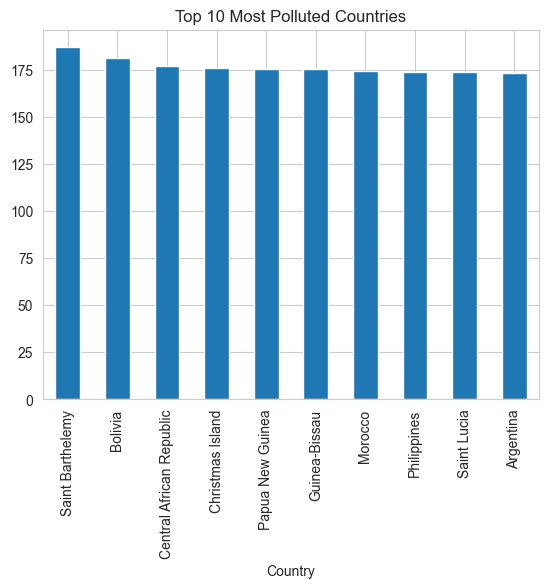

In [66]:
top_polluters = df.groupby("Country")["Total_Pollution_Index"].mean().sort_values(ascending=False).head(10)
top_polluters.plot(kind="bar")
plt.title("Top 10 Most Polluted Countries")
plt.show()


In [67]:
X = df[[
    "Total_Pollution_Index",
    "CO2_Emissions_in_MT",
    "Industrial_Waste_in_tons",
    "Renewable_Energy_Percent",
    "GDP_Per_Capita_in_USD",
    "Year_Trend",
    "CO2_Trend"
]]

y = df["Energy_Recovered_in_GWh"]


In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [69]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [70]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

print("Linear Regression Results")
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


Linear Regression Results
R2: -0.12921680721823292
MSE: 19862.03740590486
MAE: 124.1464980315375


In [71]:
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring="r2")
print("Cross-Validated R2:", cv_scores.mean())


Cross-Validated R2: -0.15883042339261264


In [72]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("Random Forest R2:", r2_score(y_test, rf_pred))


Random Forest R2: -0.18969374693526775


In [73]:
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importance_df)


                    Feature  Importance
3  Renewable_Energy_Percent    0.245894
2  Industrial_Waste_in_tons    0.180329
1       CO2_Emissions_in_MT    0.163387
4     GDP_Per_Capita_in_USD    0.158138
0     Total_Pollution_Index    0.134636
5                Year_Trend    0.098278
6                 CO2_Trend    0.019339


In [74]:
df["Pollution_Severity"] = pd.qcut(
    df["Total_Pollution_Index"],
    q=3,
    labels=["Low", "Medium", "High"]
)
le = LabelEncoder()
df["Severity_Encoded"] = le.fit_transform(df["Pollution_Severity"])


In [75]:
X_class = df[[
    "Total_Pollution_Index",
    "CO2_Emissions_in_MT",
    "Industrial_Waste_in_tons",
    "Renewable_Energy_Percent",
    "GDP_Per_Capita_in_USD"
]]

y_class = df["Severity_Encoded"]


In [76]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)


In [77]:
log_model = LogisticRegression(max_iter=5000)
log_model.fit(X_train_c, y_train_c)

y_pred_c = log_model.predict(X_test_c)

print("Accuracy:", accuracy_score(y_test_c, y_pred_c))
print(classification_report(y_test_c, y_pred_c))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        12

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



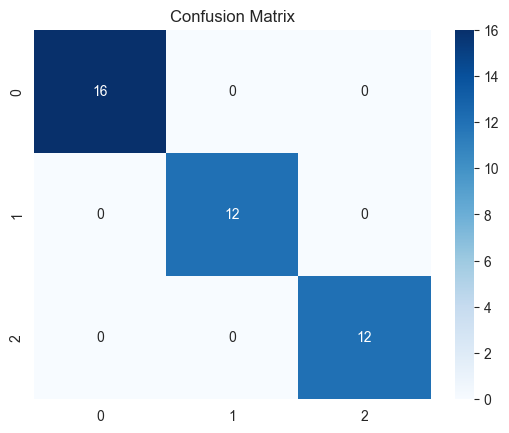

In [78]:
sns.heatmap(confusion_matrix(y_test_c, y_pred_c),
            annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [79]:
country_efficiency = df.groupby("Country").apply(
    lambda x: x["Energy_Recovered_in_GWh"].sum() /
              x["Total_Pollution_Index"].sum()
)

print(country_efficiency.sort_values(ascending=False).head(10))


Country
Cape Verde                                      10.738941
Kazakhstan                                       7.166781
Kiribati                                         6.513590
Antarctica (the territory South of 60 deg S)     5.986230
Maldives                                         5.661075
Singapore                                        5.653549
Portugal                                         5.611130
Haiti                                            5.145666
San Marino                                       4.895325
Cyprus                                           4.664278
dtype: float64
